# I. Random Graph Model Testing

In [1]:
%run functions_1.ipynb

Part 1 functions imported.


In [2]:
# For this task use the full weight matrix V.
adj_matrix = np.genfromtxt("data/sgb128Nodes41to80_weight.txt", delimiter=' ', skip_header=1)
G = nx.Graph(adj_matrix)
V = nx.adjacency_matrix(G).todense()

In [4]:
# 1. Order edges according to their weight. For this, create a matrix E of size
# n(n−1)/2 x 2 that contains the ordered list of edges so that (E(1,1),E(1,2))
# is an edge with the largest weight;
n = len(V)
E = list(G.edges(data=True))
E.sort(key=lambda e:e[2]["weight"], reverse=True)
print(n*(n-1)//2, len(E))
print(E[:10])

780 780
[(14, 38, {'weight': 0.956283}), (18, 39, {'weight': 0.926507}), (5, 18, {'weight': 0.901203}), (0, 36, {'weight': 0.891121}), (10, 32, {'weight': 0.89055}), (30, 31, {'weight': 0.876175}), (2, 35, {'weight': 0.865384}), (5, 39, {'weight': 0.837182}), (25, 37, {'weight': 0.836497}), (0, 1, {'weight': 0.830608})]


In [5]:
from collections import Counter
q3, q4, ER3, ER4, SSBM3, SSBM4 = [], [], [], [], [], []

num_3_4_cliques = Counter()
G_sub = nx.Graph()
# 2. Loop with k from 2 to n(n − 1)/2 and for each k, perform the following
# tasks on the set of first k edges, E(1 : k, 1 : 2):
for k in range(2,len(E)):
    #G_first_k_edges = nx.from_edgelist(E[:k])
    #adj = nx.adjacency_matrix(G_first_k_edges).todense()
    
    
    # (a) compute the actual number of 3-cliques q3(k) and 4-cliques q4(k);
    
    #q_cliques_counter = counter_num_cliques(G_first_k_edges)
    #print(q_cliques_counter)
    #num_3_cliques = q_cliques_counter[3]
    #q3.append(num_3_cliques)
    #q4.append(q_cliques_counter[4])
    
    G_sub, num_3_4_cliques = count_3_4_cliques(G_sub, num_3_4_cliques, E[k])
    q3.append(num_3_4_cliques[3])
    q4.append(num_3_4_cliques[4])
    
    num_nodes, num_edges = G.number_of_nodes(), k
    
    # (b) Under the Erdos-Renyi random graph model, estimate the parameter
    # p. Compute the estimated number of 3-cliques and 4-cliques (under
    # the Erdos-Renyi model), say ER3(k) and ER4(k);
    p = erdos_reyni_p_MLE(num_edges, num_nodes)
    ER3.append(erdos_reyni_estimated_q_cliques(3, num_nodes, p))
    ER4.append(erdos_reyni_estimated_q_cliques(4, num_nodes, p))
               
    # (c) Under the SSBM random graph model, estimate the parameters a
    # and b based on the number of vertices, edges, and 3-cliques, using
    # the Modified Constrained Moment Matching Algorithm 2. Compute
    # the estimated number of 3-cliques and 4-cliques (under the SSBM
    # model), say SSBM 3(k) and SSBM 4(k);
    a, b = ssbm_a_b_CMM(num_nodes, num_edges, num_3_cliques) 
    SSBM3.append(ssbm_estimated_q_cliques(3, num_nodes, a, b))
    SSBM4.append(ssbm_estimated_q_cliques(4, num_nodes, a, b))
    
    if k%50 == 0: print(f"subset {k} out of {len(E)} complete")

TypeError: unhashable type: 'AtlasView'

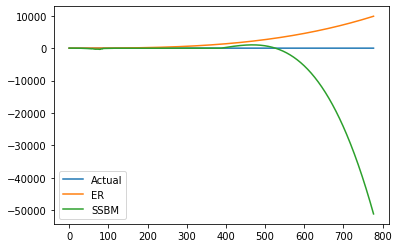

In [24]:
# 3. Plot q3, ER3 and SSBM 3 on the same plot. Estimate the amplitude
# C and exponent r from the power law y(k) ∼ Ckr by a linear fit in the
# log-log plot, after you discard the first, say 10 entries. Call C3,ER, r3,ER
# and C3,SSBM, r3,SSBM the respective parameters.
plt.plot(q3, label="Actual")
plt.plot(ER3, label="ER")
plt.plot(SSBM3, label="SSBM")
plt.legend()

In [ ]:
# 4. Plot log(q3), log(ER3) and log(C3,ER) + r3,ERlog(k) on same figure over
# the range of k utilized to estimate the exponent.


In [ ]:
# 5. Plot log(q3), log(SSBM 3) and log(C3,SSBM ) + r3,SSBM log(k) on same
# figure over the range of k utilized to estimate the exponent.


In [ ]:
# 6. Plot q4, ER4 and SSBM 4 on the same plot. Estimate the exponent r
# from the power law y(k) ∼ Ckr by a linear fit in the log-log plot, after you
# discard, say 100 first entries. Call C4,ER, r4,ER and C4,SSBM , r4,SSBM
# the respective parameters.


In [ ]:
# 7. Plot log(q4), log(ER4) and log(C4,ER) + r4,ERlog(k) on same figure over
# the range of k utilized to estimate the exponent.


In [ ]:
# 8. Plot log(q4), log(SSBM 4) and log(C4,SSBM ) + r4,SSBM log(k) on same
# figure over the range of k utilized to estimate the exponent.
# Which of the two random graph model fits better the data? Why do you think
# I recommend to discard the first 10 or 100 entries?
